# 추천 생성

이 노트북은 훈련된 모델을 사용해 추천을 생성하는 방법을 다룹니다. 세 가지 방법을 살펴 보겠습니다:

- 모델 점수
- 전역 특성 중요도
- 지역 특성 중요도

먼저 데이터와 세 번째 모델 [노트북](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/third_model.ipynb)에서 훈련된 최상의 모델을 로드합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from lime.lime_tabular import LimeTabularExplainer
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df, 
    get_split_by_author,
    get_vectorized_series, 
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import get_feature_importance
from ml_editor.model_v3 import get_question_score_from_input, get_features_from_input_text
from ml_editor.explanation_generation import FEATURE_DISPLAY_NAMES
from ml_editor.model_v2 import POS_NAMES

data_path = Path('../data/writers_with_features.csv')
df = pd.read_csv(data_path)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haesun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haesun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
clf = joblib.load(Path("../models/model_3.pkl")) 

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
features = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
features.extend(POS_NAMES.keys())

y_test = test_df["Score"] > test_df["Score"].median()
X_test = test_df[features].astype(float)

## 특성 값 사용하기

가장 간단한 방법은 모델을 사용하지 않는 것입니다. 높은 점수의 질문과 낮은 점수의 질문의 특성 값을 살펴 볼 수 있습니다. 사용자에게 추천할 대상으로 가장 큰 차이가 나는 특성을 선택합니다. 다음 코드에서 판다스로 어떻게 수행하는지 볼 수 있습니다.

In [5]:
features_and_labels = df.copy()
features_and_labels["label"] = features_and_labels["Score"] > features_and_labels["Score"].median()
features_and_labels = features_and_labels[["label"] + features].copy()

In [6]:
class_feature_values = features_and_labels.groupby("label").mean()
class_feature_values = class_feature_values.round(3)
class_feature_values = class_feature_values.transpose()
class_feature_values.rename(columns={
    False: "low score",
    True: "high score"
}, inplace=True)
class_feature_values["relative difference"] = abs(class_feature_values["high score"] - class_feature_values["low score"]) / class_feature_values["high score"]
class_feature_values.sort_values(by="relative difference", inplace=True, ascending=False)
class_feature_values

label,low score,high score,relative difference
SYM,0.001,0.000,inf
num_exclam,0.019,0.015,0.266667
PROPN,0.005,0.004,0.250000
num_colon,0.094,0.081,0.160494
num_chars,822.104,967.032,0.149869
num_diff_words,177.428,206.859,0.142276
num_quotes,0.216,0.199,0.085427
num_periods,0.814,0.754,0.079576
num_commas,0.673,0.728,0.075549
ADV,0.013,0.014,0.071429


## 특성 중요도 사용하기

특성 값을 비교하는 것이 좋은 출발점이지만 더 좋은 방법이 있습니다. 모델을 훈련했기 때문에 모델의 특성 중요도를 사용해 글을 향상하기 위한 요소를 추천할 수 있습니다.

In [7]:
k = 5

print("전체 %s개의 특성을 사용합니다." % len(features))
print("상위 %s개의 특성 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, np.array(features))[:k]]))

print("\n하위 %s개의 특성 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, np.array(features))[-k:]]))

Using 30 features in total
Top 5 importances:

num_questions: 0.048
num_chars: 0.048
num_periods: 0.048
num_diff_words: 0.047
ADJ: 0.047

Bottom 5 importances:

SYM: 0.014
X: 0.01
num_exclam: 0.0072
num_semicolon: 0.007
CONJ: 0


## 모델 점수 사용하기

특성 중요도 외에도 모델의 출력 점수를 사용해 질문 품질을 나타내는 점수를 사용자에게 제공할 수 있습니다.

In [8]:
example_question = """
Is displaying a binary class enough to guide a user
"""
q_score = get_question_score_from_input(example_question)

print("좋은 질문일 가능성은 %s 퍼센트입니다" % q_score * 100)

100%|██████████| 1/1 [00:00<00:00, 1808.67it/s]

0.42 probability of being a good question


## LIME을 사용한 지역 추천

앞선 방법에서 추천은 일반적인 정보를 기반으로 하고 점수만 특정 입력 질문에 따라 다릅니다. 사용자가 제공한 입력에 맞는 추천을 제공하고 싶습니다. LIME을 사용해 이런 방법에 대해 알아 보겠습니다.

### 테스트 데이터 샘플에서

먼저 테스트 세트의 샘플에 이 방법을 적용해 보겠습니다.

In [9]:
explainer = LimeTabularExplainer(
    train_df[features].values,
    feature_names=features,
    class_names=["low", "high"],
)

In [10]:
idx = 8
exp = explainer.explain_instance(
    test_df[features].iloc[idx, :],
    clf.predict_proba,
    num_features=10,
    labels=(1,),
)
print("Q: %s" % test_df["full_text"].iloc[idx])
exp.show_in_notebook(show_table=True, show_all=False)

Q: Where can subject matter experts volunteer to work on proofing the technical details in fiction? I am not a writer (yet!), but I have been working in the computer field for over 10 years and would love to put in some time volunteering my services as a subject matter expert (SME) for programming and computer related story components.  Is there a central place that such SMEs can peddle their knowledge?  Is anyone in need here?



<출력 그래프 예시>
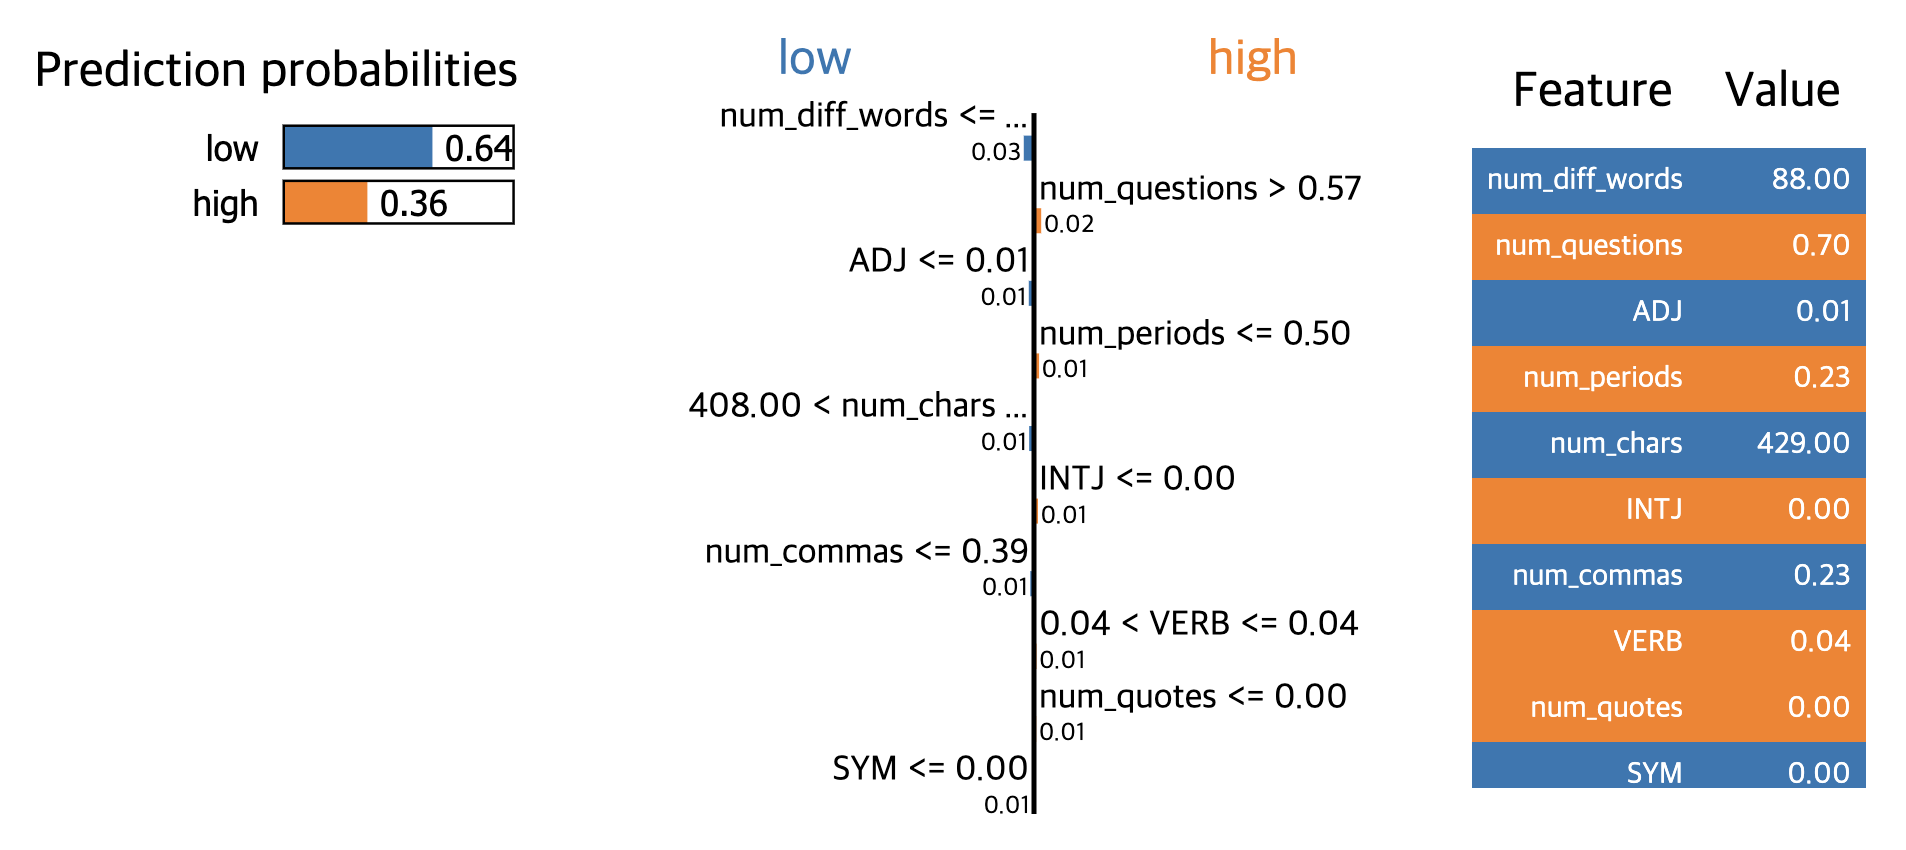

In [11]:
exp.as_list()

[('num_diff_words <= 88.00', -0.0329257520779456),
 ('num_questions > 0.57', 0.019194719243937564),
 ('ADJ <= 0.01', -0.018074705867191333),
 ('num_periods <= 0.50', 0.017856389387462656),
 ('408.00 < num_chars <= 655.00', -0.014165944223979921),
 ('INTJ <= 0.00', 0.013102559664622187),
 ('0.04 < VERB <= 0.04', 0.009912309790784633),
 ('num_commas <= 0.39', -0.009455322534965185),
 ('SYM <= 0.00', -0.008546578347862389),
 ('0.02 < ADP <= 0.02', -0.007461390451457582)]

주어진 질문에 대해 설명 리스트를 추천으로 제시할 수 있습니다.

### 새로운 샘플에서

이 방법을 확장하여 새로운 샘플에 대한 설명을 출력해 보겠습니다.

In [12]:
feats = get_features_from_input_text(example_question)

exp = explainer.explain_instance(
    feats,
    clf.predict_proba,
    num_features=10,
    labels=(1,),
)
print("Q: %s" % example_question)
exp.show_in_notebook(show_table=True, show_all=False)

100%|██████████| 1/1 [00:00<00:00, 2495.12it/s]


Q: 
Is displaying a binary class enough to guide a user



<출력 그래프 예시>
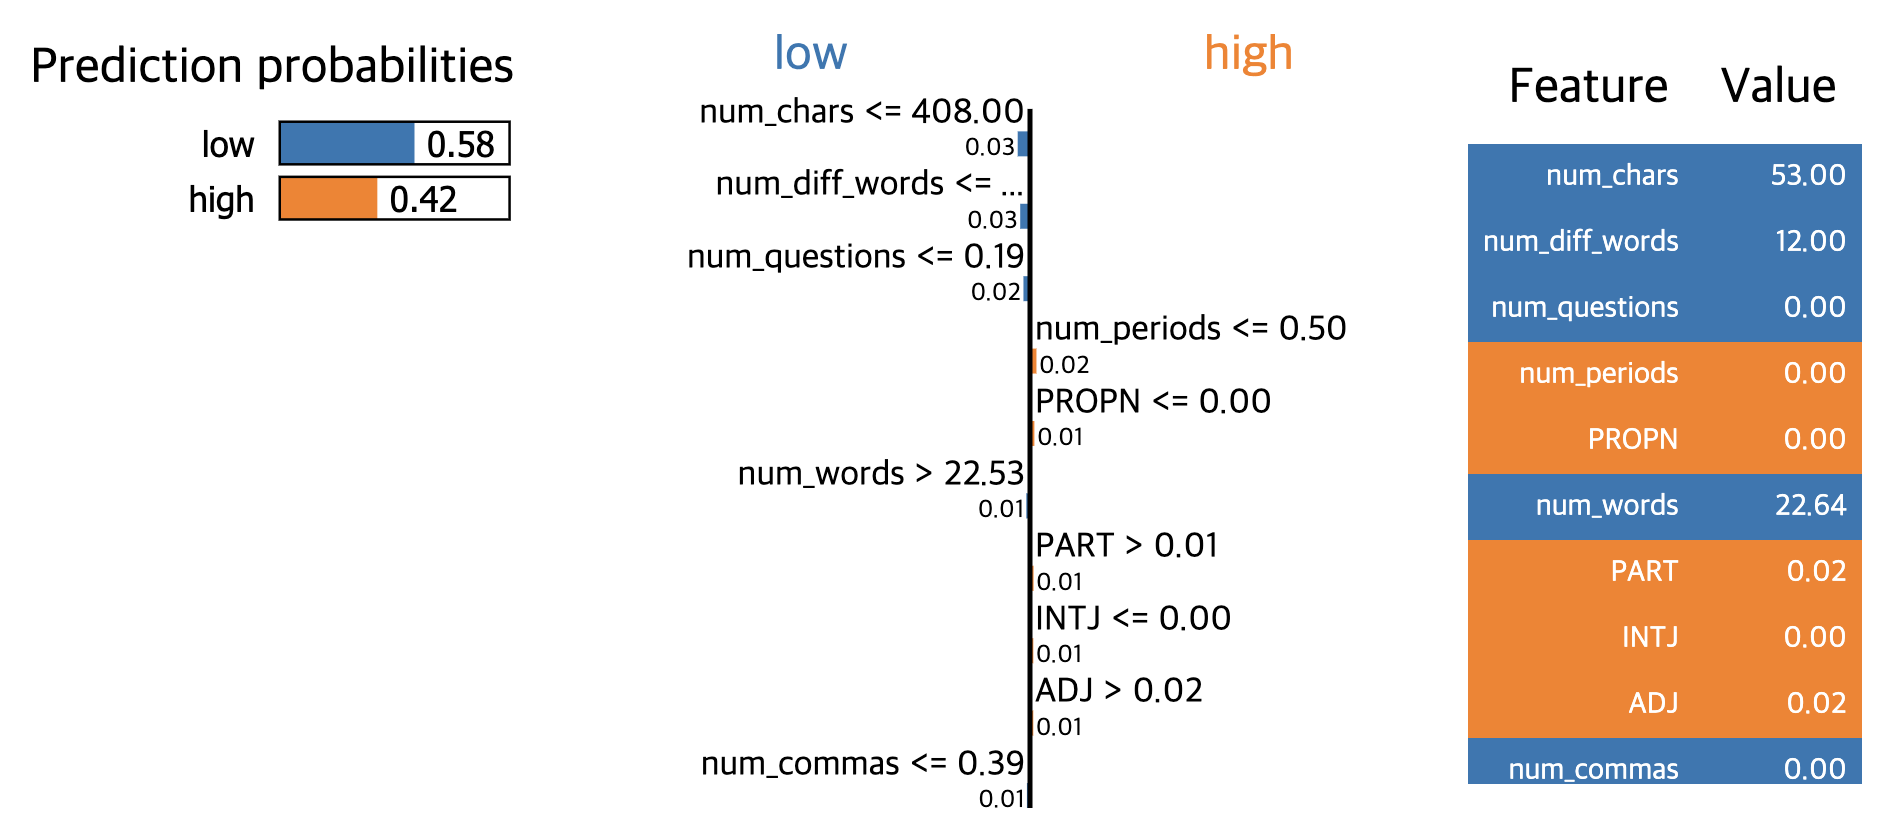

In [13]:
exp.as_list()

[('num_chars <= 408.00', -0.03430412151667103),
 ('num_diff_words <= 88.00', -0.028117681988336085),
 ('num_questions <= 0.19', -0.017854114606540693),
 ('num_periods <= 0.50', 0.014646406717009904),
 ('num_words > 22.53', -0.011956613619059437),
 ('INTJ <= 0.00', 0.011639490118873995),
 ('num_commas <= 0.39', -0.010230322602568806),
 ('PROPN <= 0.00', 0.009384931738615604),
 ('ADJ > 0.02', 0.008136061898255246),
 ('NUM <= 0.00', 0.007070478183556914)]

아래 사용자에게 추천을 명확하게 보여주기 위해 몇 개의 함수를 만들었습니다.

In [14]:
def parse_explanations(exp_list):
    global FEATURE_DISPLAY_NAMES
    parsed_exps = []
    for feat_bound, impact in exp_list:
        conditions = feat_bound.split(" ")

        # 추천으로 표현하기 힘들기 때문에
        # 1 <= a < 3 와 같은 이중 경계 조건은 무시합니다
        if len(conditions) == 3:
            feat_name, order, threshold = conditions

            simple_order = simplify_order_sign(order)
            recommended_mod = get_recommended_modification(simple_order, impact)

            parsed_exps.append(
                {
                    "feature": feat_name,
                    "feature_display_name": FEATURE_DISPLAY_NAMES[feat_name],
                    "order": simple_order,
                    "threshold": threshold,
                    "impact": impact,
                    "recommendation": recommended_mod,
                }
            )
    return parsed_exps

def get_recommended_modification(simple_order, impact):
    bigger_than_threshold = simple_order == ">"
    has_positive_impact = impact > 0

    if bigger_than_threshold and has_positive_impact:
        return "낮출 필요 없습니다"
    if not bigger_than_threshold and not has_positive_impact:
        return "높이세요"
    if bigger_than_threshold and not has_positive_impact:
        return "낮추세요"
    if not bigger_than_threshold and has_positive_impact:
        return "높일 필요 없습니다"

def simplify_order_sign(order_sign):
    if order_sign in ["<=", "<"]:
        return "<"
    if order_sign in [">=", ">"]:
        return ">"
    return order_sign
    
parsed_exps = parse_explanations(exp.as_list())        
parsed_exps

[{'feature': 'num_chars',
  'feature_display_name': '문자 개수',
  'order': '<',
  'threshold': '408.00',
  'impact': -0.03430412151667103,
  'recommendation': '높이세요'},
 {'feature': 'num_diff_words',
  'feature_display_name': '어휘 다양성',
  'order': '<',
  'threshold': '88.00',
  'impact': -0.028117681988336085,
  'recommendation': '높이세요'},
 {'feature': 'num_questions',
  'feature_display_name': '물음표 빈도',
  'order': '<',
  'threshold': '0.19',
  'impact': -0.017854114606540693,
  'recommendation': '높이세요'},
 {'feature': 'num_periods',
  'feature_display_name': '마침표 빈도',
  'order': '<',
  'threshold': '0.50',
  'impact': 0.014646406717009904,
  'recommendation': '높일 필요 없습니다'},
 {'feature': 'num_words',
  'feature_display_name': '단어 개수',
  'order': '>',
  'threshold': '22.53',
  'impact': -0.011956613619059437,
  'recommendation': '낮추세요'},
 {'feature': 'INTJ',
  'feature_display_name': '감탄사 빈도',
  'order': '<',
  'threshold': '0.00',
  'impact': 0.011639490118873995,
  'recommendation': '높일 필요 없

In [15]:
def get_recommendation_string_from_parsed_exps(exp_list):
    recommendations = []
    for feature_exp in exp_list:
        recommendation = "%s %s" % (
            feature_exp["feature_display_name"],
            feature_exp["recommendation"],
        )
        recommendations.append(recommendation)
    return recommendations

get_recommendation_string_from_parsed_exps(parsed_exps)

['문자 개수 높이세요',
 '어휘 다양성 높이세요',
 '물음표 빈도 높이세요',
 '마침표 빈도 높일 필요 없습니다',
 '단어 개수 낮추세요',
 '감탄사 빈도 높일 필요 없습니다',
 '쉼표 빈도 높이세요',
 '고유 명사 빈도 높일 필요 없습니다',
 '형용사 빈도 낮출 필요 없습니다',
 '숫자 빈도 높일 필요 없습니다']

앞의 추천이 훨씬 이해하기 쉽고 피드백을 위해 사용자에게 출력할 수 있습니다. 다음의 예를 확인해 보세요.

In [16]:
def get_recommendation_and_prediction_from_text(input_text, num_feats=10):
    global clf, explainer
    feats = get_features_from_input_text(input_text)

    pos_score = clf.predict_proba([feats])[0][1]
    exp = explainer.explain_instance(
        feats, clf.predict_proba, num_features=num_feats, labels=(1,)
    )
    parsed_exps = parse_explanations(exp.as_list())
    recs = get_recommendation_string_from_parsed_exps(parsed_exps)
    return recs, pos_score


recos, score = get_recommendation_and_prediction_from_text(example_question)
print("점수: %s" % score)
print(*recos, sep="\n")

100%|██████████| 1/1 [00:00<00:00, 1968.23it/s]


점수: 0.42
문자 개수 높이세요
어휘 다양성 높이세요
물음표 빈도 높이세요
감탄사 빈도 높일 필요 없습니다
고유 명사 빈도 높일 필요 없습니다
마침표 빈도 높일 필요 없습니다
쉼표 빈도 높이세요
단어 개수 낮추세요
형용사 빈도 낮출 필요 없습니다
부사 빈도 낮출 필요 없습니다


## 연속적인 추천 따르기

제안한 워크플로를 테스트하기 위해 질문을 입력하고 모델 추천을 몇 차례 따라가면서 질문이 향상되는지 확인해 보겠습니다.

In [17]:
recos, score = get_recommendation_and_prediction_from_text(
    """
I want to learn how models are made
"""
)
print("점수: %s" % score)
print(*recos, sep="\n")

100%|██████████| 1/1 [00:00<00:00, 1589.96it/s]


점수: 0.41
문자 개수 높이세요
어휘 다양성 높이세요
형용사 빈도 높이세요
마침표 빈도 높일 필요 없습니다
물음표 빈도 높이세요
한정사 빈도 높일 필요 없습니다
쉼표 빈도 높이세요
단어 개수 낮추세요
고유 명사 빈도 높일 필요 없습니다
감탄사 빈도 높일 필요 없습니다


텍스트 길이, 질문 개수, 어휘의 다양성을 늘려 보겠습니다.

In [18]:
recos, score = get_recommendation_and_prediction_from_text(
    """
I'd like to learn about building machine learning products. 
Are there any good product focused resources? 
Would you be able to recommend educational books?
"""
)

print("점수: %s" % score)
print(*recos, sep="\n")

100%|██████████| 1/1 [00:00<00:00, 1470.65it/s]


점수: 0.49
문자 개수 높이세요
어휘 다양성 높이세요
물음표 빈도 낮출 필요 없습니다
쉼표 빈도 높이세요
고유 명사 빈도 높일 필요 없습니다
한정사 빈도 높일 필요 없습니다
감탄사 빈도 높일 필요 없습니다
부사 빈도 높이세요
기호 빈도 높이세요
구두점 빈도 높일 필요 없습니다


좋습니다. 점수가 증가했네요. 한 번 더 추천을 따라서 텍스트 길이, 어휘 다양성, 물음표를 늘려 보겠습니다.

In [19]:
recos, score = get_recommendation_and_prediction_from_text(
    """
I'd like to learn more about ML, specifically how to build ML products.
When I attempt to build such products, I always face the same challenge: 
how do you go beyond a model?
What are the best practices to use a model in a concrete application?
Are there any good product focused resources? 
Would you be able to recommend educational books?
"""
)

print("점수: %s" % score)
print(*recos, sep="\n")

100%|██████████| 1/1 [00:00<00:00, 962.22it/s]


점수: 0.5
문자 개수 높이세요
어휘 다양성 높이세요
물음표 빈도 낮출 필요 없습니다
마침표 빈도 높일 필요 없습니다
한정사 빈도 높일 필요 없습니다
감탄사 빈도 높일 필요 없습니다
숫자 빈도 높일 필요 없습니다
불변화사 빈도 낮출 필요 없습니다
형용사 빈도 낮출 필요 없습니다
콜론 빈도 낮추세요


이제 머신러닝 파워드 에디팅 추천 애플리케이션을 만들었습니다! 분류 성능 위해 반복하거나 사용자가 이해하기 쉬운 특성을 만드는 것처럼 향상 방법은 **많습니다**. 이렇게 향상시키려면 <머신러닝 파워드 애플리케이션> 책의 3부에 있는 권장 사항을 따르세요.